In [1]:
import pandas as pd
import altair as alt

In [2]:
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
df = pd.read_csv("data/irradiance.csv")

In [4]:
# show first five rows
df.head()

,device_id,timestamp,irradiance
0,9,2024-06-01 00:00:00,0
1,9,2024-06-01 01:00:00,0
2,9,2024-06-01 02:00:00,0
3,9,2024-06-01 03:00:00,0
4,9,2024-06-01 04:00:00,0


## Reshape data for interpolation

In [5]:
# ensure proper data type
df['timestamp'] =  pd.to_datetime(df['timestamp'])

# ensure we just have a single device, then drop device column
df[df['device_id'] == 9]
df = df[['timestamp', 'irradiance']]

# set index to timestamp and 
df = df.set_index('timestamp').sort_index()

# resample so we have one entry for every hour
df_hourly = df.resample('1h').asfreq()

# add column to indicate if data was missing
df_hourly['missing'] = df_hourly['irradiance'].isna()

In [6]:
# preview some rows
df_hourly.iloc[35:40]

,irradiance,missing
timestamp,,
2024-06-02 11:00:00,NaN,True
2024-06-02 12:00:00,NaN,True
2024-06-02 13:00:00,964.0,False
2024-06-02 14:00:00,851.0,False
2024-06-02 15:00:00,NaN,True


## Run interpolation function

In [7]:
df_interpolated = df_hourly.interpolate(method='time')
df_interpolated.iloc[35:40]

,irradiance,missing
timestamp,,
2024-06-02 11:00:00,857.50,True
2024-06-02 12:00:00,910.75,True
2024-06-02 13:00:00,964.00,False
2024-06-02 14:00:00,851.00,False
2024-06-02 15:00:00,703.00,True


## Make plot

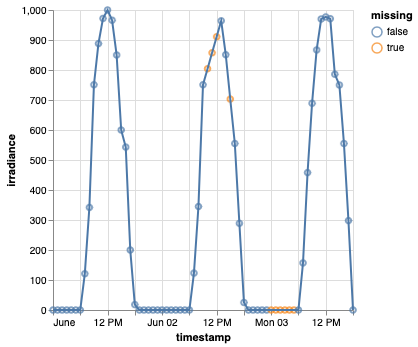

In [8]:
line = alt.Chart(df_interpolated.reset_index()).mark_line().encode(
    x='timestamp:T',
    y='irradiance:Q',
)

points = alt.Chart(df_interpolated.reset_index()).mark_point().encode(
    x='timestamp:T',
    y='irradiance:Q',
    color="missing",
)

points + line